<a href="https://colab.research.google.com/github/agamthind96/Deep-Learning-Projects/blob/main/Transfer_learning_in_TensorFlow_Part_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Transfer Learning with TensorFlow Part 3 : Scaling-Up (Food Vision Mini)

We have seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale-up to all of the classes in Food101 (101 total classes of food)

Our goal is to beat the original Food101  paper with 10% of training(leveraging the power of Deep Learning)

Original Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

The baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we are using GPU.
!nvidia-smi

Wed Dec  8 09:03:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Helper Functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-08 09:03:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-08 09:03:49 (71.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions from our notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes : working with less data.

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we are downloading comes from original Food101 dataset but has been preprocessed using image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-12-08 09:03:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   185MB/s    in 8.2s    

2021-12-08 09:04:00 (189 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images classes are there ?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with Transfer Learning on 10% of Food101 classes

Here are the steps that we are going to take :
* Creates ModelCheckpoint cllback.
* Create a data augmentation layer right into the model.
* Build a headless(no top layers) Functional EfficientNetB0 backboned model (we will create our own output layer)
* Compile our model
* Feature Extract for 5 full passes (5 epochs on train dataset and testing it on 15% of test data to save epoch time)

In [ ]:
# Create Checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                         save_weights_only=True,
                                         monitor="val_accuracy",
                                         save_best_only=True)

In [ ]:
# Create Data Augmentation layer to incorporate right inot the model.
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
"""
# Setup Data Augmentation
data_augmentation = Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      preprocessing.RandomZoom(0.2)
], name="data_augmentation")
"""

'\n# Setup Data Augmentation\ndata_augmentation = Sequential([\n      preprocessing.RandomFlip("horizontal"),\n      preprocessing.RandomRotation(0.2),\n      preprocessing.RandomHeight(0.2),\n      preprocessing.RandomWidth(0.2),\n      preprocessing.RandomZoom(0.2)\n], name="data_augmentation")\n'

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers.
inputs = layers.Input(shape=(224,224,3), name="input_layer")
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we have created.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 64s 202ms/step - loss: 3.1486 - accuracy: 0.3248 - val_loss: 2.5565 - val_accuracy: 0.4123
Epoch 2/5
237/237 [==============================] - 47s 196ms/step - loss: 1.8637 - accuracy: 0.5789 - val_loss: 2.1440 - val_accuracy: 0.4733
Epoch 3/5
237/237 [==============================] - 47s 195ms/step - loss: 1.4502 - accuracy: 0.6665 - val_loss: 1.9945 - val_accuracy: 0.4918
Epoch 4/5
237/237 [==============================] - 47s 195ms/step - loss: 1.2041 - accuracy: 0.7283 - val_loss: 1.9021 - val_accuracy: 0.5087
Epoch 5/5
237/237 [==============================] - 47s 196ms/step - loss: 1.0245 - accuracy: 0.7798 - val_loss: 1.8529 - val_accuracy: 0.5122


In [ ]:
# Evaluate on the whole test data.
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 104s 131ms/step - loss: 1.5393 - accuracy: 0.5977


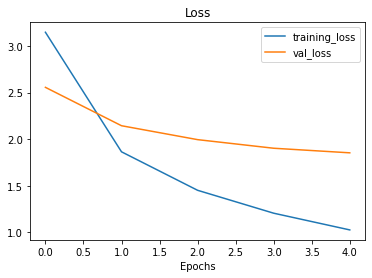

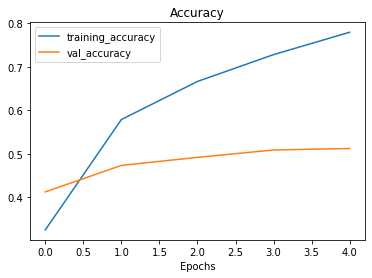

In [ ]:
# Plot Accuracy and Loss curves
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

In [ ]:
# Unfreeze all of the layers in the base model.
base_model.trainable = True

# Refreeze every layer except the last 5 layers.
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# What layers in the model are trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(model.layers[1].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs=10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                     callbacks=[create_tensorboard_callback(dir_name="Transfer_Learning",
                                                                                          experiment_name="Fine_Tuning_all_classes_10_percent")])

Saving TensorBoard log files to: Transfer_Learning/Fine_Tuning_all_classes_10_percent/20211207-101739
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


 50/237 [=====>........................] - ETA: 25s - loss: 0.3050 - accuracy: 0.9419

KeyboardInterrupt: ignored

In [ ]:
# Evaluate on entire test data.
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.5635 - accuracy: 0.6066


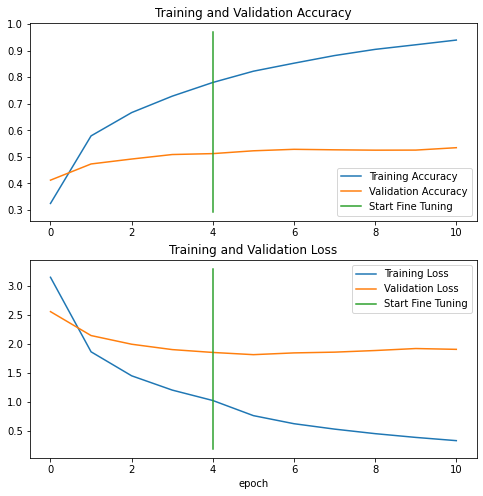

In [ ]:
# Compare the plots of feature extraction and fine-tuning histories.
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and loading our model.

To use our model in an external application, we need to save it and export it somewhere.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Tensorflow/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Tensorflow/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load and evalaute our model.
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Tensorflow/')

In [ ]:
# Evaluate loaded model and compare its performance to previous model.
loaded_model.evaluate(test_data)


790/790 [==============================] - 104s 131ms/step - loss: 1.5635 - accuracy: 0.6066


[1.5635349750518799, 0.6066138744354248]

## Evaluating the performance of big model across all different classes.

Let's make some predictions, visualize them, and then find out which predictions were the *most* wrong.

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-12-08 09:04:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   195MB/s    in 0.2s    

2021-12-08 09:04:50 (195 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load the saved model.
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate the loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 141s 164ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model.


In [ ]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 121s 151ms/step


In [ ]:
# How many predictions are there ?
len(preds_probs)

25250

In [ ]:
import numpy as np

In [ ]:
# Let's see how our predictions looks like
test_data.class_names[np.argmax(preds_probs[0])]

'gyoza'

In [ ]:
sum(preds_probs[0])

1.0000000616546507

In [ ]:
# Get the predicted classes of each label.
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# To get our test labels we need to unravel our test_data batch set.
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently labels are one hot encoded.
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Evalauting our model's predictions.

One way to check that our model's prediction array is in the same order as our test labels array is to find accuracy score.


In [ ]:
# Let's try Scikit_learn Accuarcy score function.
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evalaute results.
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

### Make a Confusion Matrix

In [ ]:
from helper_functions import make_confusion_matrix


In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names, figsize=(150,150),
                      text_size=20)

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                      y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of classification-report.
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items.
for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframes.
import pandas as pd
f1_scores = pd.DataFrame({"class_names" : list(class_f1_scores.keys()),
                         "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

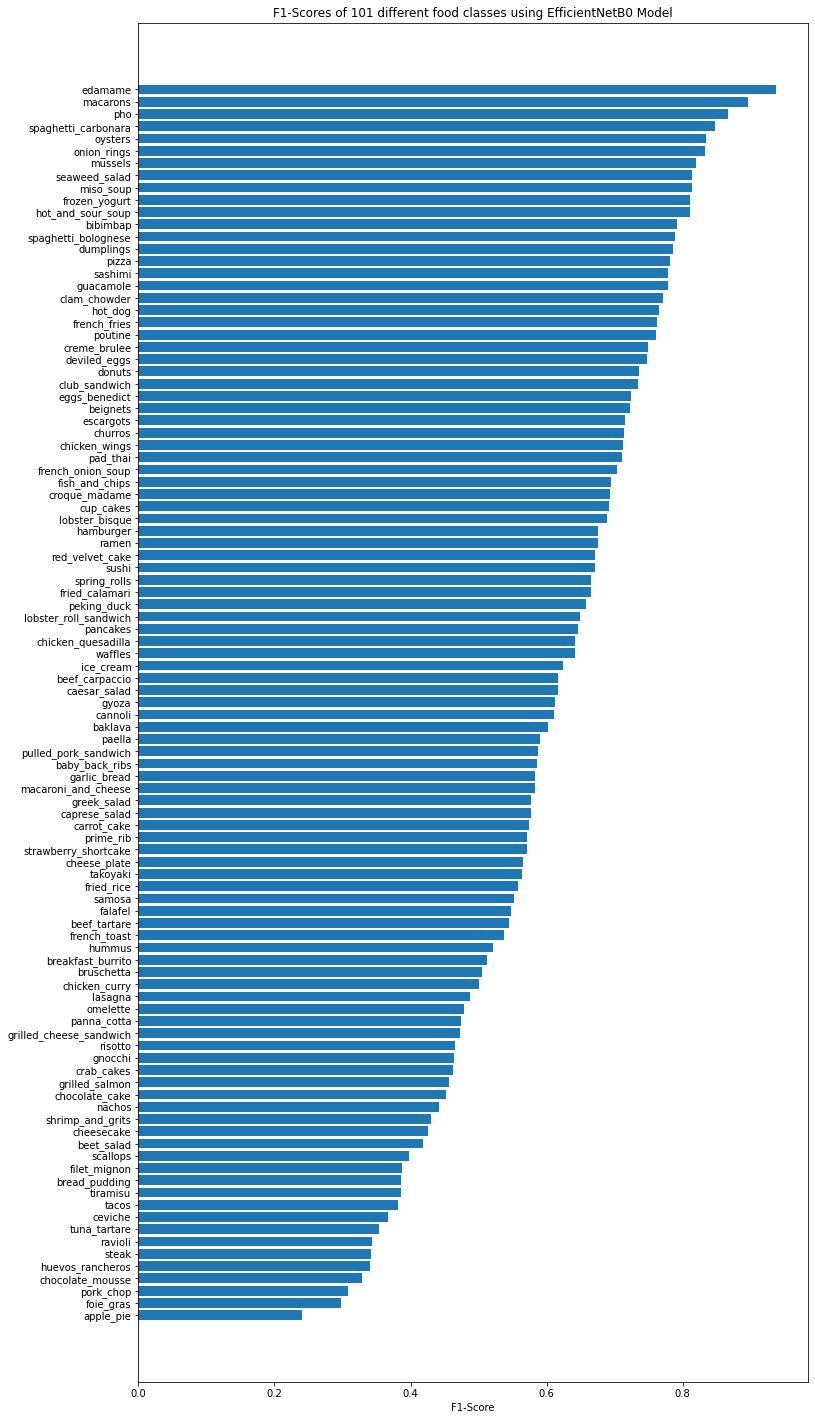

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Scores of 101 different food classes using EfficientNetB0 Model")
ax.invert_yaxis();



## Visualizing predictions on Custom images.

To visulaize our model's predictions on our own images, we will need a function to load and preprocess the images.

* Read in a target image filepath using tf.io.read_file().
* Turn the image into a Tensor using tf.io.decode_image().
* Resize the image tensor to be of same size as the images our model has trained using tf.image.resize().
* Scale the image to get al of the pixel value between 0 & 1. (if necessary)

In [ ]:
# Create a function to load and preprocess image.
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshapes into specified shape
   (img_shape, img_shape, color_channels=3).

   Args :
      filename (str) :  path to target image.
      image_shape (int) : height/width dimension of target image size.
      scale(bool) : scale pixel values from 0-255 to 0-1 if required.

   Returns :
      Image tensor of shape (img_shape, img_shape, 3)

  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale - Yes/No
  if scale:
    return img/255.0 # rescale the image and get all values between 0&1.
  else:
    return img




Now we've got a function to load and preprocess target images, let's now write some code to visualize images , their target label and predictions.

Specifically we will write some code to :

*  1. Load a few random images from test dataset.
*  2. Make predictions on loaded images.
*  3. Plot the original image(s) along with model's predictions, prediction probability and truth labels.


101_food_classes_10_percent/test/creme_brulee/624714.jpg
101_food_classes_10_percent/test/creme_brulee/2826303.jpg
101_food_classes_10_percent/test/nachos/308790.jpg


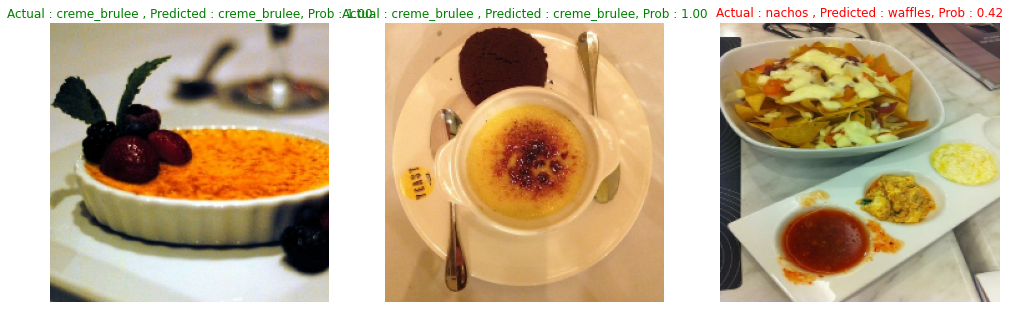

In [ ]:
# Make predictions on a series of random images.
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class :
    title_color='g'
  else:
    title_color='r'

  plt.title(f"Actual : {class_name} , Predicted : {pred_class}, Prob : {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);



## Finding the most wrong predictions.

To find out where our model is most wrong, let's write some code to find out the following :

* 1. Get all of the image file paths in the test dataset using list_files() method.
* 2. Crate a Pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
* 3. Use DataFrame to find all the wrong predictions.(when the ground truth label doesn't match the prediction)
* 4. Sort the DataFrame based on wrong predictions (having the highest predictions probabilities at the top).
* 5. Visualize the images with the highest prediction probabilities but have the wrong predictions.

In [ ]:
# Get all of the image file paths in the test dataset.
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# Create a DataFrame for these filepaths
pred_df = pd.DataFrame({"img_paths" : filepaths,
                        "y_true" : y_labels,
                        "y_pred" : pred_classes,
                        "pred_conf" : preds_probs.max(axis=1),
                        "y_true_classname" : [class_names[i] for i in y_labels],
                        "y_pred_classname" : [class_names[i] for i in pred_classes]})

pred_df[:10]

img_paths  ...       y_pred_classname
0  b'/content/101_food_classes_10_percent/test/ap...  ...                  gyoza
1  b'/content/101_food_classes_10_percent/test/ap...  ...              apple_pie
2  b'/content/101_food_classes_10_percent/test/ap...  ...              apple_pie
3  b'/content/101_food_classes_10_percent/test/ap...  ...   pulled_pork_sandwich
4  b'/content/101_food_classes_10_percent/test/ap...  ...              prime_rib
5  b'/content/101_food_classes_10_percent/test/ap...  ...  lobster_roll_sandwich
6  b'/content/101_food_classes_10_percent/test/ap...  ...              cup_cakes
7  b'/content/101_food_classes_10_percent/test/ap...  ...              apple_pie
8  b'/content/101_food_classes_10_percent/test/ap...  ...                 samosa
9  b'/content/101_food_classes_10_percent/test/ap...  ...              apple_pie

[10 rows x 6 columns]

In [ ]:
# Find out in our DataFrame which predictions are wrong.
pred_df["pred_correct"] = pred_df["y_true"]==pred_df["y_pred"]
pred_df[:10]

img_paths  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False
5  b'/content/101_food_classes_10_percent/test/ap...  ...         False
6  b'/content/101_food_classes_10_percent/test/ap...  ...         False
7  b'/content/101_food_classes_10_percent/test/ap...  ...          True
8  b'/content/101_food_classes_10_percent/test/ap...  ...         False
9  b'/content/101_food_classes_10_percent/test/ap...  ...          True

[10 rows x 7 columns]

In [ ]:
# Sort our DataFrame to have most wrong predictions at the top.
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head()

img_paths  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False

[5 rows x 7 columns]

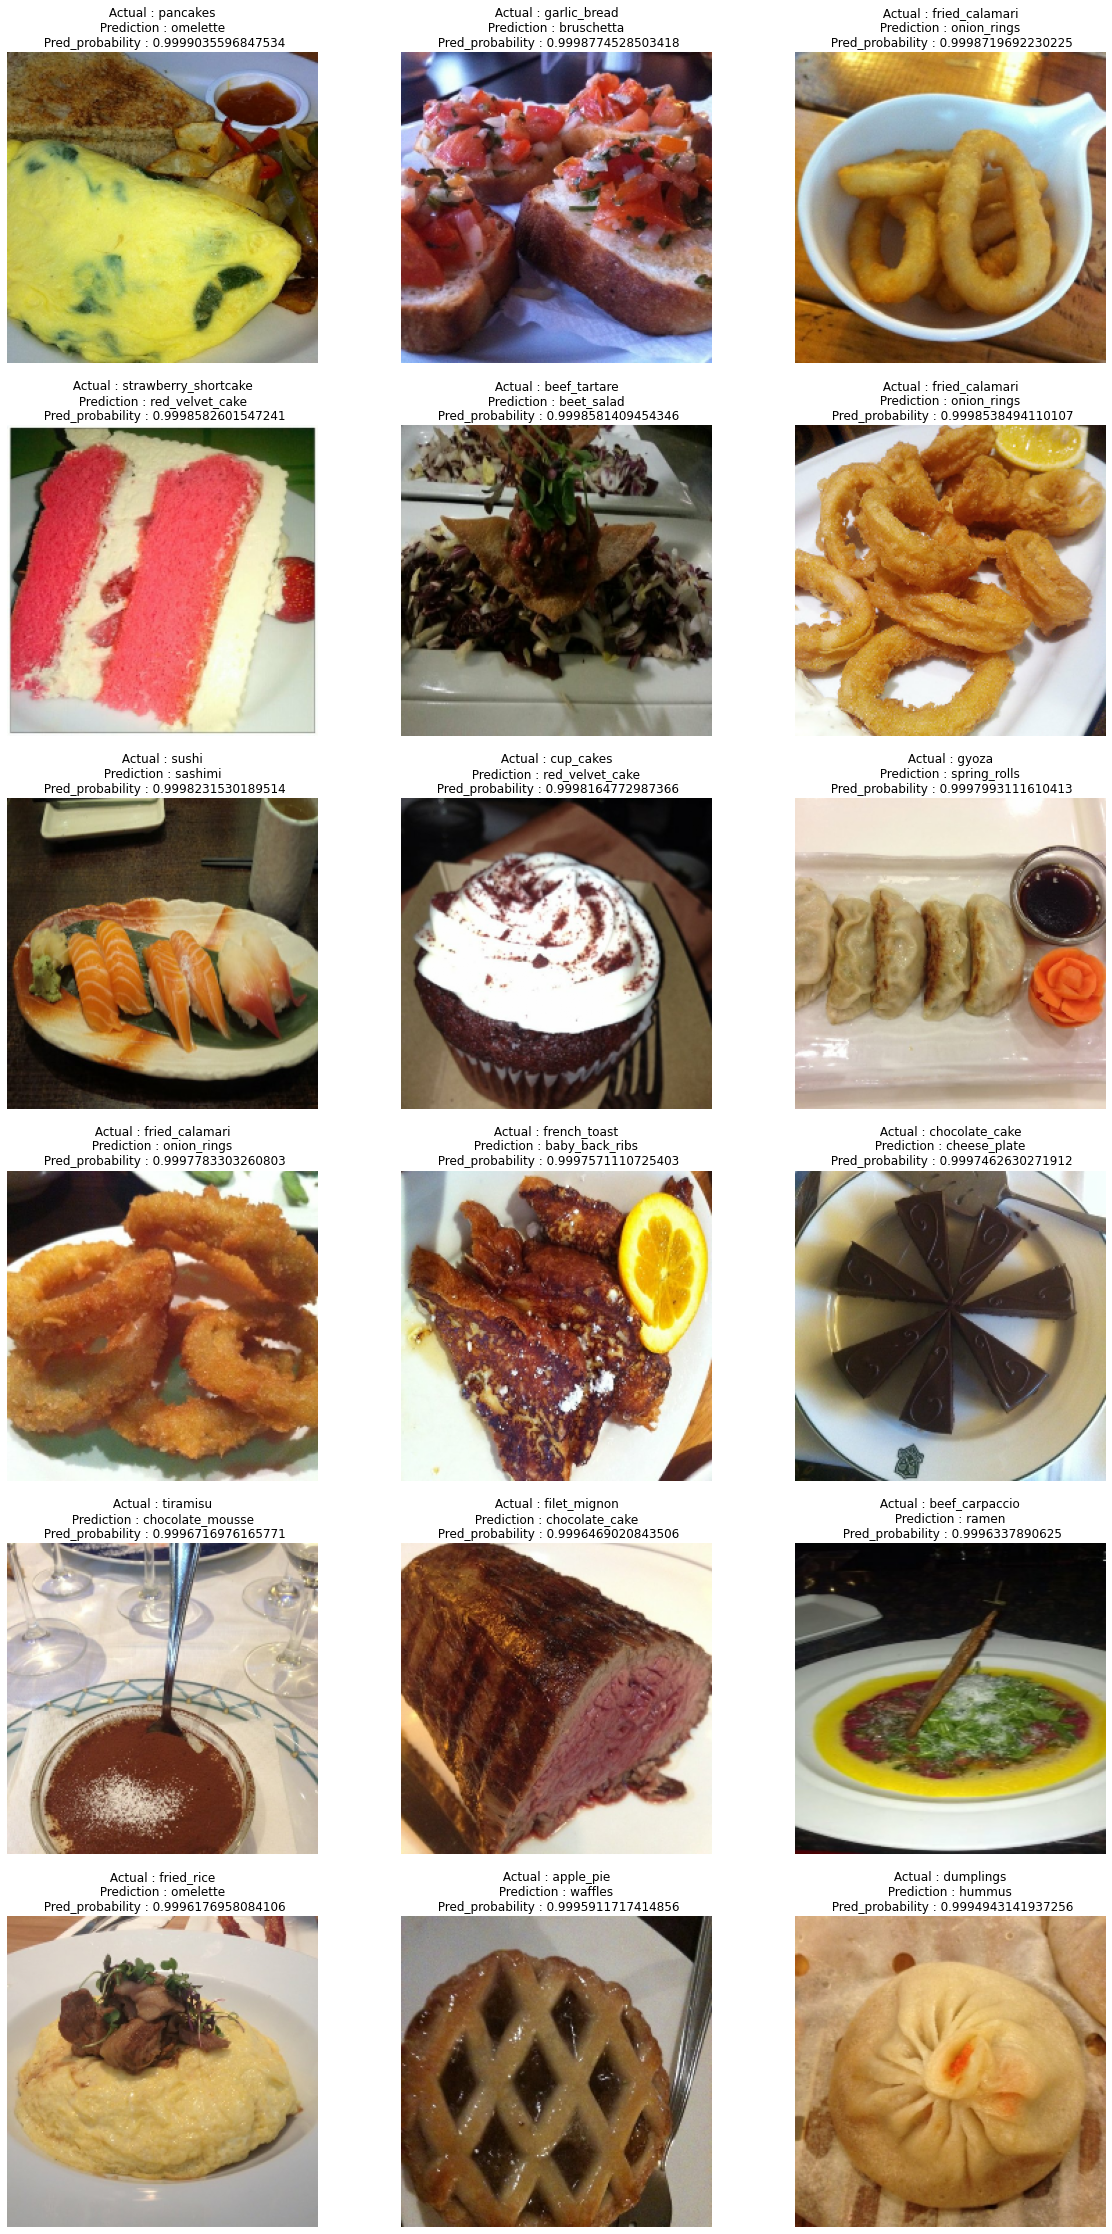

In [ ]:
# Visualize the test data samples which have the wrong predictions but highest pred probability.
images_to_view = 18
start_index = 10
plt.figure(figsize=(20,40))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(6,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f" Actual : {y_true_classname} \n Prediction : {y_pred_classname} \n Pred_probability : {pred_prob}")
  plt.axis(False)


### Testing our model on custom image.

In [ ]:
img = load_and_prep_image(filename="/content/Sashimi.jpg", scale=False)
img_expanded = tf.expand_dims(img, axis=0)
predicted = model.predict(img_expanded)
predicted_class = class_names[predicted.argmax()]
predicted_class

'sushi'

(-0.5, 223.5, 223.5, -0.5)

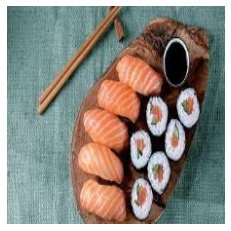

In [ ]:
plt.imshow(img/255.0)
plt.axis(False)